In [2]:
import os
import dask
import numpy as np
import warnings
import abc

from glob import glob
from astropy.io import fits
from typing import Sequence, Union, List, Dict, Any

In [3]:
REQUEST = Dict[int, Sequence[str]]

In [4]:
class FileDataInterface(abc.ABC, dict):
    """Partial implementation for classes used to get data from COS FITS files that subclasses the python dictionary."""
    def __init__(self):
        super().__init__(self)

    @abc.abstractmethod
    def get_header_data(self, hdu: fits.HDUList, header_request: REQUEST, defaults: Dict[str, Any]):
        """Get header data."""
        pass

    @abc.abstractmethod
    def get_table_data(self, hdu: fits.HDUList, table_request: REQUEST):
        """Get table data."""
        pass

In [5]:
class FileData(FileDataInterface):
    """Class that acts as a dictionary, but with a constructor that grabs FITS file info from typical COS data
    products.
    """
    def __init__(self, hdu: fits.HDUList, header_request: REQUEST = None, table_request: REQUEST = None,
                 header_defaults: Dict[str, Any] = None, bytes_to_str: bool = True):
        """Initialize and create the possible corresponding spt file name."""
        super().__init__()

        if header_request:
            self.get_header_data(hdu, header_request, header_defaults)

        if table_request:
            self.get_table_data(hdu, table_request)

        if bytes_to_str:
            self._convert_bytes_to_strings()

    def _convert_bytes_to_strings(self):
        """Convert byte-string arrays to strings."""
        for key, value in self.items():
            if isinstance(value, np.ndarray):
                if value.dtype.char == 'S':
                    self[key] = value.astype(str)

    @classmethod
    def from_file(cls, filename, *args, **kwargs):
        with fits.open(filename) as hdu:
            return cls(hdu, *args, **kwargs)

    def get_header_data(self, hdu: fits.HDUList, header_request: REQUEST, header_defaults: dict = None):
        """Get header data."""
        for ext, keys in header_request.items():
            for key in keys:
                if header_defaults is not None and key in header_defaults:
                    self[key] = hdu[ext].header.get(key, default=header_defaults[key])

                else:
                    self[key] = hdu[ext].header[key]

    def get_table_data(self, hdu: fits.HDUList, table_request: REQUEST):
        """Get table data from the TableHDU."""
        for ext, keys in table_request.items():
            for key in keys:
                if key in self:
                    self[f'{key}_{ext}'] = hdu[ext].data[key]

                else:
                    self[key] = hdu[ext].data[key]

    def combine(self, other, right_name):
        """Combine two FileData dictionaries into one."""
        for key, value in other.items():
            if key in self:
                self[f'{right_name}_{key}'] = value

            else:
                self[key] = value

In [14]:
def get_exposure_data(filename: str, header_request: REQUEST = None, table_request: REQUEST = None,
                      header_defaults: Dict[str, Any] = None):
    try:
        with fits.open(filename) as hdu:
            if header_request or table_request:
                data = FileData(hdu, header_request, table_request, header_defaults)
                data['FILENAME'] = filename

    except OSError as e:
        warnings.warn(f'Bad file found: {filename}\n{str(e)}', Warning)

        return
    return data


In [13]:
x1d = glob('/user/jhernandez/fuvtds/calibration_data/17249/11/*x1d.fits')

In [15]:
data = get_exposure_data(x1d[0])

UnboundLocalError: local variable 'data' referenced before assignment

In [10]:
gd71 = glob.glob('/grp/hst/cdbs/calspec/gd71_mod_011.fits')

In [11]:
hdr0 = fits.getheader(x1d[0], 0)
data = fits.getdata(x1d[0], 1)

gd71 = fits.getdata(gd71[0], 1)

In [70]:
iseg = 0
w  = data['wavelength'][iseg,:] # selects the segment of the data
f = data['flux'][iseg,:]

# wavelength range per cenwave and segment
wvumin = 1610.0
wvumax = 1785.0

# this carves out the x1d data within the bounds initiated the above
#so similar to how i carve out certain pixels 
ixu = np.argwhere((w >=wvumin) & (w <= wvumax))

# all the index locations we want
ixu = ixu[:,0]

delwv = 5 #Angstroms
nbins = round((wvumax - wvumin) / delwv) # Amount of 5-Angstrom bins

# amount of data points in each bin
binsize = round(len(ixu) / nbins) # amount of data points / 
                                #   amount of 5-Angstrom bins

ixbin = np.arange(nbins+1) # 36 points, 0-35
ixbin = ixbin.astype(int) # change array to interger array
xbin  = np.zeros(nbins+1) # array of zeros, size 36


# xbin : defines the edges of each bin by index number
#ei 1016 - 1424 are the edges of the first bin
for i in ixbin:
    xbin[i] = min(ixu)+i*binsize
xbin = xbin.astype(int) 

# pre-populates new arrays with zeros
#these will house the averaged points between the index edges above
wbin = np.zeros(nbins)
fbin = np.zeros(nbins)

# average each bin
for i in ixbin[:-1]:
    wbin[i] = np.average(w[xbin[i]:xbin[i+1]])
    fbin[i] = np.average(f[xbin[i]:xbin[i+1]])

# three decimal points for each wavelength bin
wbin = np.around(wbin, decimals=3)

# data from the model spectra from calspec
wmod = gd71['WAVELENGTH']
fmod = gd71['FLUX']

# get flux points corresponding to the wavelength bins we have
fmodbin = np.interp(wbin, wmod, fmod)

# subtract the two together
resid = (fbin - fmodbin) / fmodbin

# if there are nan values, replace with 0.0
resid[np.isnan(resid)] = 0.0

In [2]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

<function matplotlib.pyplot.show(close=None, block=None)>

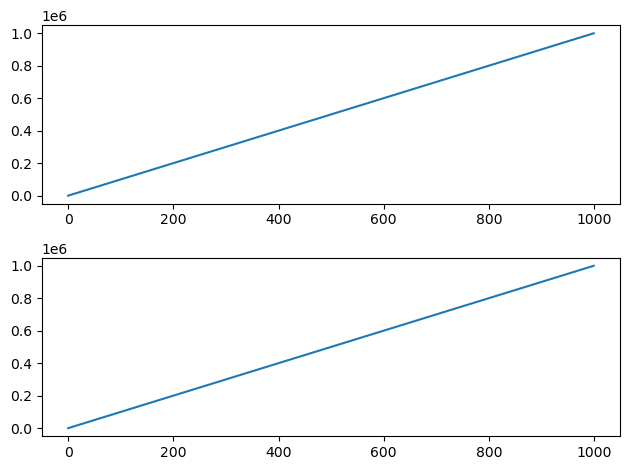

In [21]:
fig = plt.figure(tight_layout=True)
gs = gridspec.GridSpec(2,1)

ax = fig.add_subplot(gs[0])
ax.plot(np.arange(0,1e6, 1000))

ax = fig.add_subplot(gs[1])
ax.plot(np.arange(0,1e6, 1000))

plt.show

In [12]:
hdr0

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                    1 / Number of standard extensions                  
DATE    = '2023-10-07'         / date this file was written (yyyy-mm-dd)        
FILENAME= 'lf2011i7q_x1d.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'COS   '             / identifier for instrument used to acquire data 
EQUINOX =               2000.0 / equinox of celestial coord. system             
                            